In [1]:
import gc
from tqdm import tqdm
from tqdm._tqdm import trange
import numpy as np
import pandas as pd
from pylab import rcParams
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from scipy.stats import probplot
from fbprophet import Prophet

%matplotlib inline

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

import warnings
warnings.filterwarnings("ignore")

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.std.*` instead of `tqdm._tqdm.*`
  This is separate from the ipykernel package so we can avoid doing imports until


In [3]:
calendar = pd.read_csv('calendar.csv')
validation = pd.read_csv('sales_train_validation.csv')
submission = pd.read_csv('sample_submission.csv')

submission = submission[submission.id.str.find('validation')!=-1]
validation = validation.merge(submission, on='id', how='left')
validation = validation.drop(['item_id','dept_id','cat_id','store_id','state_id'], axis=1)

valid_cols = ['d_'+str(1913+i) for i in range(1,29)]
validation.columns = validation.columns.tolist()[:-28]+valid_cols
validation.columns

Index(['id', 'd_1', 'd_2', 'd_3', 'd_4', 'd_5', 'd_6', 'd_7', 'd_8', 'd_9',
       ...
       'd_1932', 'd_1933', 'd_1934', 'd_1935', 'd_1936', 'd_1937', 'd_1938',
       'd_1939', 'd_1940', 'd_1941'],
      dtype='object', length=1942)

In [4]:
submission

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
validation

,id,d_1,d_2,d_3,d_4,d_5,d_6,d_7,d_8,d_9,...,d_1932,d_1933,d_1934,d_1935,d_1936,d_1937,d_1938,d_1939,d_1940,d_1941
0,HOBBIES_1_001_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,HOBBIES_1_002_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,HOBBIES_1_004_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,HOBBIES_1_005_CA_1_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
30485,FOODS_3_823_WI_3_validation,0,0,2,2,0,3,1,4,1,...,0,0,0,0,0,0,0,0,0,0
30486,FOODS_3_824_WI_3_validation,0,0,0,0,0,5,0,1,1,...,0,0,0,0,0,0,0,0,0,0
30487,FOODS_3_825_WI_3_validation,0,6,0,2,2,4,1,8,5,...,0,0,0,0,0,0,0,0,0,0
30488,FOODS_3_826_WI_3_validation,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [11]:
calendar

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,2016-06-15,11620,Wednesday,5,6,2016,d_1965,NaN,NaN,NaN,NaN,0,1,1
1965,2016-06-16,11620,Thursday,6,6,2016,d_1966,NaN,NaN,NaN,NaN,0,0,0
1966,2016-06-17,11620,Friday,7,6,2016,d_1967,NaN,NaN,NaN,NaN,0,0,0
1967,2016-06-18,11621,Saturday,1,6,2016,d_1968,NaN,NaN,NaN,NaN,0,0,0


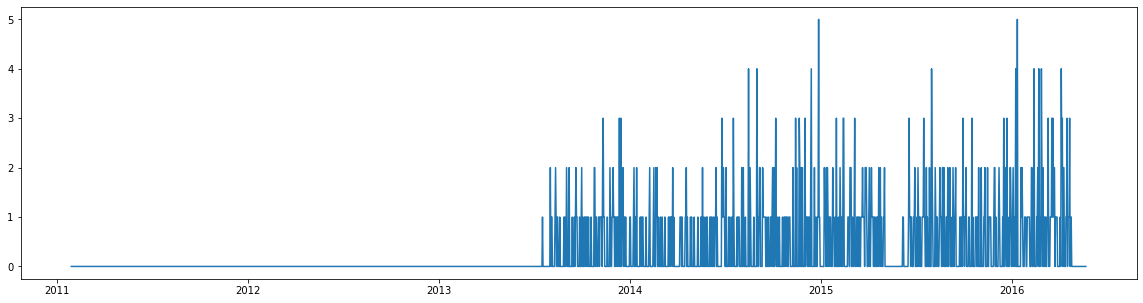

In [6]:
item1 = validation.iloc[0]
item1 = item1.drop('id').T.reset_index().merge(calendar[['d','date']], left_on='index', right_on='d', how='left').drop(['index','d'], axis=1)
item1.columns = ['y', 'ds']
item1.y = item1.y.astype('float')
item1.ds = item1.ds.astype('datetime64')

rcParams['figure.figsize'] = 20, 5
plt.plot(item1.ds, item1.y)

INFO:numexpr.utils:NumExpr defaulting to 4 threads.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


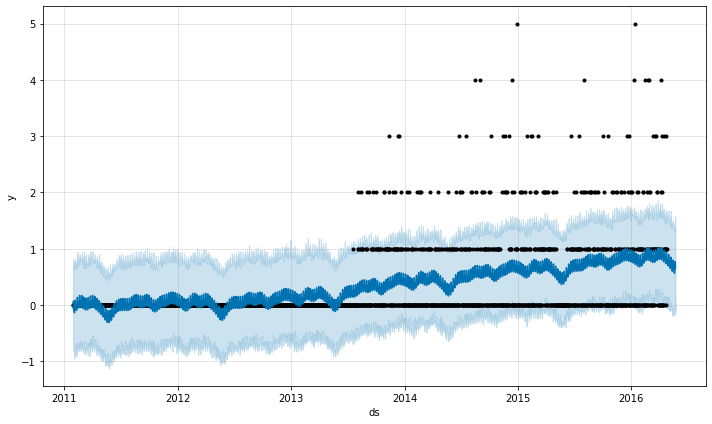

In [7]:
item = validation.iloc[0]
item = item.drop('id').T.reset_index().merge(calendar[['d','date']], left_on='index', right_on='d', how='left').drop(['index','d'], axis=1)
item.columns = ['y', 'ds']
item.y = item.y.astype('float')
item.ds = item.ds.astype('datetime64')
train_item = item.iloc[:-28]
valid_item = item.iloc[-28:]

ph = Prophet()
ph.fit(train_item)
forecast = ph.predict(item[['ds']])
figure = ph.plot(forecast)
figure.show()

In [14]:
for i in trange(len(validation)):
    item = validation.iloc[i]
    item_id = item.id
    item = item.drop('id').T.reset_index().merge(calendar[['d','date']], left_on='index', right_on='d', how='left').drop(['index','d'], axis=1)
    item.columns = ['y', 'ds']
    item.y = item.y.astype('float')
    item.ds = item.ds.astype('datetime64')
    train_item = item.iloc[:-28]
    valid_item = item.iloc[-28:]

    ph = Prophet()
    ph.fit(train_item)
    forecast = ph.predict(valid_item[['ds']])
    validation.iloc[i, -28:] = forecast.yhat.tolist()


  0%|          | 0/30490 [00:00<?, ?it/s]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 1/30490 [00:02<24:10:15,  2.85s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 2/30490 [00:05<24:38:06,  2.91s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 3/30490 [00:09<25:55:58,  3.06s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 4/30490 [00:12<26:43:17,  3.16s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 5/30490 [00:18<34:06:15,  4.03s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 6/30490 [00:23<35:49:46,  4.23s/it]INFO:fbprophet:Disabling dai


  0%|          | 52/30490 [03:56<34:14:52,  4.05s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 53/30490 [04:00<34:35:24,  4.09s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 54/30490 [04:03<33:07:39,  3.92s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 55/30490 [04:06<31:04:07,  3.67s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 56/30490 [04:10<30:42:27,  3.63s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 57/30490 [04:14<31:48:13,  3.76s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 58/30490 [04:18<32:50:49,  3.89s/it]INFO:fbpro


  0%|          | 104/30490 [07:35<37:45:18,  4.47s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 105/30490 [07:39<37:50:23,  4.48s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 106/30490 [07:43<35:14:51,  4.18s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 107/30490 [07:47<36:42:06,  4.35s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 108/30490 [07:51<35:29:27,  4.21s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 109/30490 [07:59<43:54:07,  5.20s/it]INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.

  0%|          | 110/30490 [08:04<43:19:58,  5.13s/it]INF

KeyboardInterrupt: 

In [15]:
train_item

,y,ds
0,3.0,2011-01-29
1,0.0,2011-01-30
2,1.0,2011-01-31
3,0.0,2011-02-01
4,3.0,2011-02-02
...,...,...
1908,1.0,2016-04-20
1909,3.0,2016-04-21
1910,1.0,2016-04-22
1911,0.0,2016-04-23


In [16]:
submission_prophet = validation[['id']+valid_cols]
submission_prophet.columns = ['id']+['F'+str(i) for i in range(1,29)]
submission_prophet_eval = submission_prophet.copy()
submission_prophet_eval.id = submission_prophet_eval.id.apply(lambda _id:_id.replace('_validation','_evaluation'))
submission_prophet = pd.concat([submission_prophet, submission_prophet_eval])
submission_prophet.head(15)

,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,HOBBIES_1_001_CA_1_validation,0.762079,0.822200,0.706412,0.696686,0.749047,0.896207,0.772794,0.721267,0.780071,...,0.651705,0.798458,0.675334,0.624892,0.685664,0.571381,0.564116,0.619986,0.771778,0.654178
1,HOBBIES_1_002_CA_1_validation,0.146287,0.157986,0.175204,0.227097,0.254862,0.345304,0.287672,0.234905,0.254977,...,0.428313,0.504959,0.430300,0.357695,0.355614,0.355438,0.386724,0.391156,0.456105,0.371445
2,HOBBIES_1_003_CA_1_validation,0.645193,0.654611,0.653015,0.666135,0.705048,0.780701,0.692263,0.639402,0.650339,...,0.731923,0.812581,0.728790,0.680056,0.694457,0.697557,0.714916,0.757453,0.835977,0.749541
3,HOBBIES_1_004_CA_1_validation,1.566469,1.244058,1.182927,1.592049,1.588727,2.679225,3.288700,1.547761,1.236035,...,1.689056,2.790207,3.407331,1.670697,1.359666,1.306562,1.719978,1.716911,2.803410,3.404509
4,HOBBIES_1_005_CA_1_validation,0.695617,0.615750,0.715357,0.647219,0.719799,1.160935,1.070505,0.548401,0.484008,...,0.865820,1.375082,1.352676,0.896989,0.895920,1.074694,1.084426,1.231914,1.743369,1.717126
5,HOBBIES_1_006_CA_1_validation,0.573470,0.365873,0.328861,0.458494,0.369839,0.715000,0.562916,0.694313,0.494347,...,0.571218,0.896279,0.720627,0.825484,0.596558,0.533864,0.633959,0.512476,0.822148,0.632583
6,HOBBIES_1_007_CA_1_validation,0.251016,0.272483,0.242564,0.263965,0.303498,0.349889,0.329942,0.295675,0.314792,...,0.326649,0.363170,0.333507,0.289919,0.300338,0.259412,0.270112,0.299503,0.336551,0.308274
7,HOBBIES_1_008_CA_1_validation,10.020475,9.445960,10.398893,9.480426,10.409502,11.215954,8.909656,9.495693,8.889320,...,9.609480,10.536577,8.374628,9.127199,8.707366,9.841147,9.127825,10.283779,11.335619,9.289370
8,HOBBIES_1_009_CA_1_validation,0.110288,0.157585,-0.125141,-0.052356,-0.052430,0.364285,0.095419,-0.022757,0.052763,...,0.021761,0.465806,0.218153,0.114800,0.198681,-0.053337,0.043836,0.061591,0.489551,0.225528
9,HOBBIES_1_010_CA_1_validation,0.457388,0.401581,0.412202,0.335421,0.442309,0.566176,0.878016,0.410993,0.358618,...,0.393506,0.522435,0.839161,0.376888,0.329174,0.347799,0.278942,0.393694,0.525390,0.845059
